# Long-term potentiation (LTP)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/LTP" folder

In [2]:
data_folder = "data/10-LTP/group6"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.abf")
data_files

Folders:
Files:


['data/10-LTP/group6/group6_induction2.abf',
 'data/10-LTP/group6/group6_post2.abf',
 'data/10-LTP/group6/group6_baseline.abf',
 'data/10-LTP/group6/group6_post.abf',
 'data/10-LTP/group6/group6_baseline2.abf',
 'data/10-LTP/group6/group6_induction.abf']

### **If the data is divided in exactly 3 files** ('baseline', 'induction', and 'post_induction'), copy/paste the names here below 


In [3]:
data_files_baseline = ['data/10-LTP/group6/group6_baseline.abf']
data_files_post = ['data/10-LTP/group6/group6_post.abf']

### If you ran the code window above, the you should skip the next one

### **If the data is spread across many files**, group them together into into 3 folders ('baseline', 'induction', and 'post_induction'):

Double check that the folder names are correct here:

In [4]:
################################################################################################
##### Only run this cell if your data is split into multiple .abf files for each condition #####
################################################################################################

# Select all the data files for each condition
data_folder_baseline = 'data/10-LTP/baseline/'
data_folder_post = 'data/10-LTP/post_induction/'

# -------------------------------------------------------------------------------------------------
data_files_baseline = [f"{data_folder_baseline}/{f}" for f in os.listdir(data_folder_baseline) if f.endswith('.abf')]
data_files_baseline.sort()
data_files_post = [f"{data_folder_post}/{f}" for f in os.listdir(data_folder_post) if f.endswith('.abf')]
data_files_post.sort()

# data_folder_post2 = 'data/10-LTP/post_second_induction/'
# data_files_post2 = [f"{data_folder_post2}/{f}" for f in os.listdir(data_folder_post2) if f.endswith('.abf')]
# data_files_post2.sort()
# data_files_post = data_files_post + data_files_post2

print(f"Num baseline files: {len(data_files_baseline)}")
print(f"Num post files: {len(data_files_post)}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/10-LTP/baseline/'

We will load all the traces from across all files and combine them into a single Trace object

In [5]:
traces_baseline = combine_traces_across_files(data_files_baseline, average_across_sweeps=False, recording_mode="I clamp")
num_baseline_traces = traces_baseline.num_sweeps

traces_post = combine_traces_across_files(data_files_post, average_across_sweeps=False, recording_mode="I clamp")
num_post_traces = traces_post.num_sweeps

Trace('data/10-LTP/group6/group6_post.abf')
Number of sweeps: 150
Points per sweep: 6,000
Duration per sweep: 0.600 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


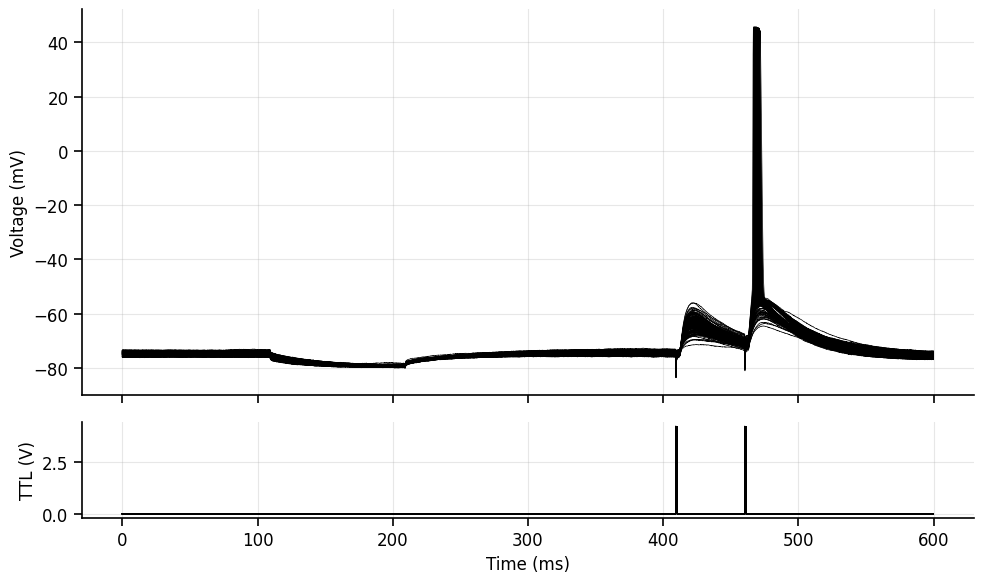

In [52]:
all_files = data_files_baseline + data_files_post
traces = combine_traces_across_files(all_files, average_across_sweeps=False, recording_mode="I clamp")
traces.num_baseline_sweeps = num_baseline_traces
traces.num_post_sweeps = num_post_traces
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
# %matplotlib widget
%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=False, plot_ttl=True, sweep='all', time_units=time_units, height_ratios=(4,1))
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline voltages (mV): [-73.751  -73.5129 -73.7068 ... -75.6115 -75.8153 -75.9574]


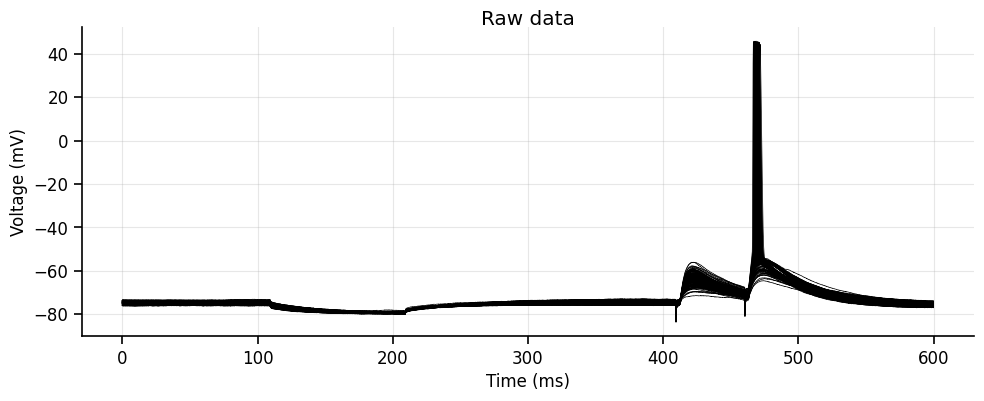

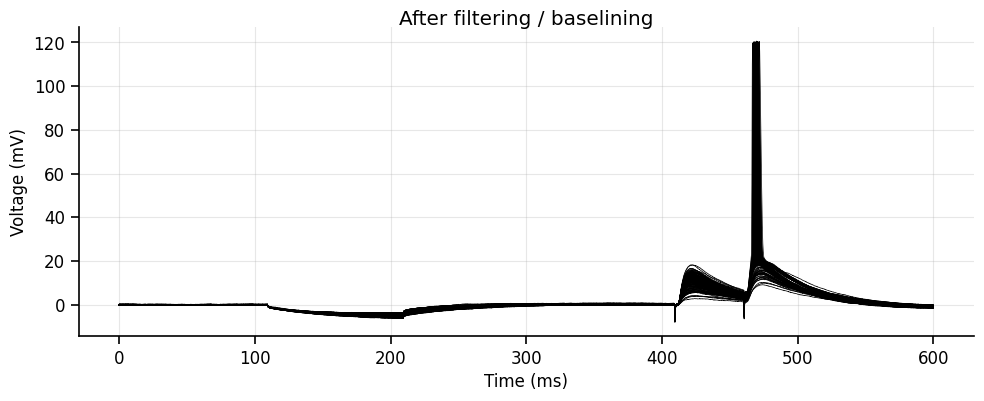

In [53]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False  # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1, apply_to_voltage=True)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 2000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = 0  # Start time for baseline subtraction
    test_pulse_start = traces.get_step_events(threshold=traces.current_data[0,0]-10, channel='current', edge='rising', polarity='negative', time_units=time_units, sweep=0)
    end_baseline = test_pulse_start[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'voltage')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering / baselining', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [54]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure the test pulse

First let's measure the test pulse to monitor for changes in the access resistance.

We need to define the relevant time window where we want to measure:

In [55]:
test_pulse_start = traces.get_step_events(threshold=traces.current_data[0,0]-10, channel='current', edge='rising', polarity='negative', time_units=time_units, sweep=0)
test_pulse_end = traces.get_step_events(threshold=traces.current_data[0,0]-10, channel='current', edge='falling', polarity='negative', time_units=time_units, sweep=0)
print(f"Test pulse time: {test_pulse_start} to {test_pulse_end} ms")

Test pulse time: [109.2] to [209.2] ms


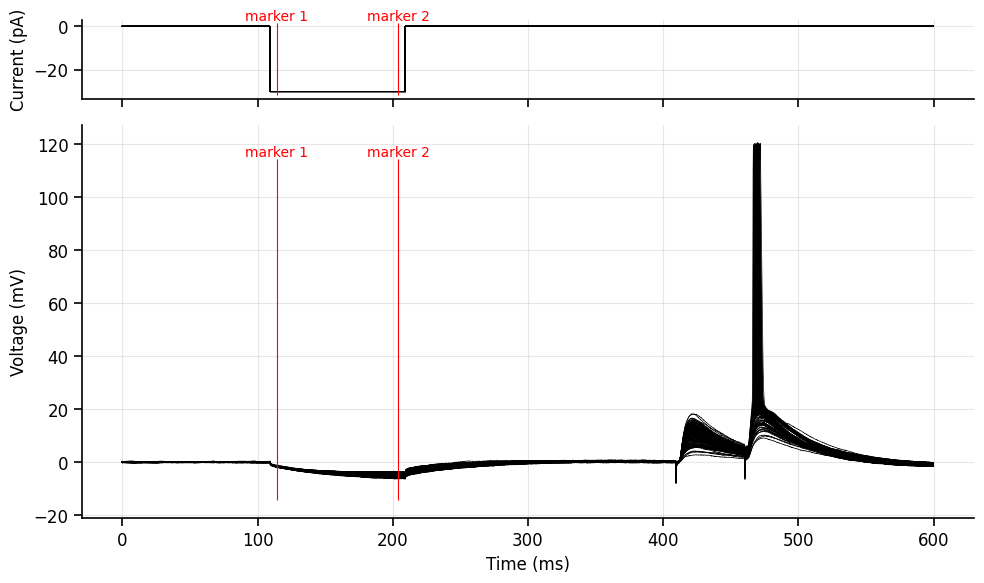

In [56]:
marker_1 = test_pulse_start[0] + 5  # Start of the marker window (in ms)
marker_2 = test_pulse_end[0] - 5    # End of the marker window (in ms)

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,5))
# ax1.set_xlim(start_time,end_time)
plt.show()

Next we will be using the timepoints from the markers we defined above.

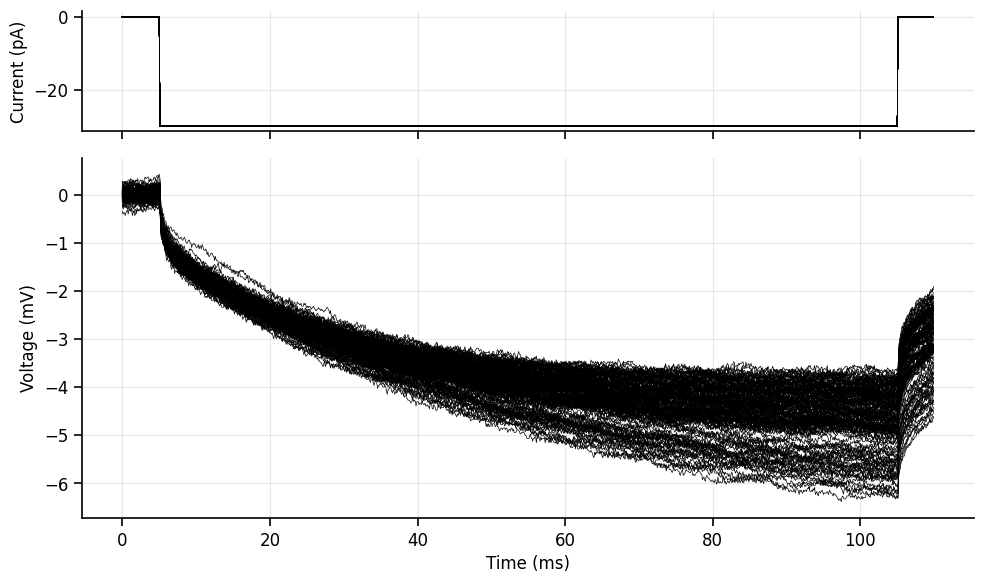

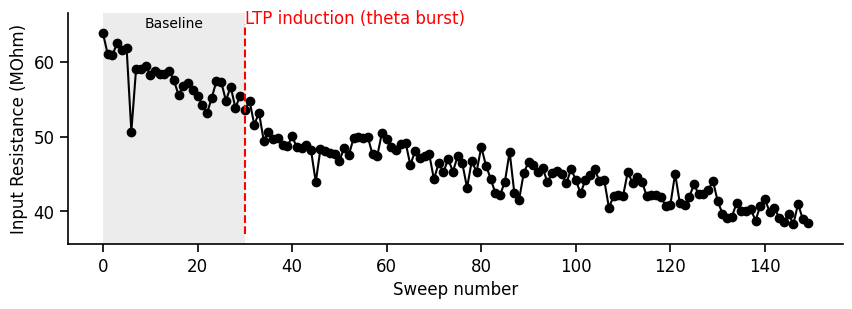

In [57]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

current_steps, voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                           measurement_type=measurement_type, time_units=time_units)

test_pulse_traces = traces.crop(timepoint=marker_1-10, timepoint_2=marker_2+10, time_units=time_units)
test_pulse_traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=(1,3))
plt.show()

test_pulse_current = -0.1 #nA
resistance = voltage_steps/test_pulse_current #mV / nA = MOhm

%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,resistance[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, resistance[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
ax.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('Input Resistance (MOhm)')
ax.set_xlabel('Sweep number')
plt.show()

### 3.1. Check that there haven't been any sudden big changes in the bridge balance

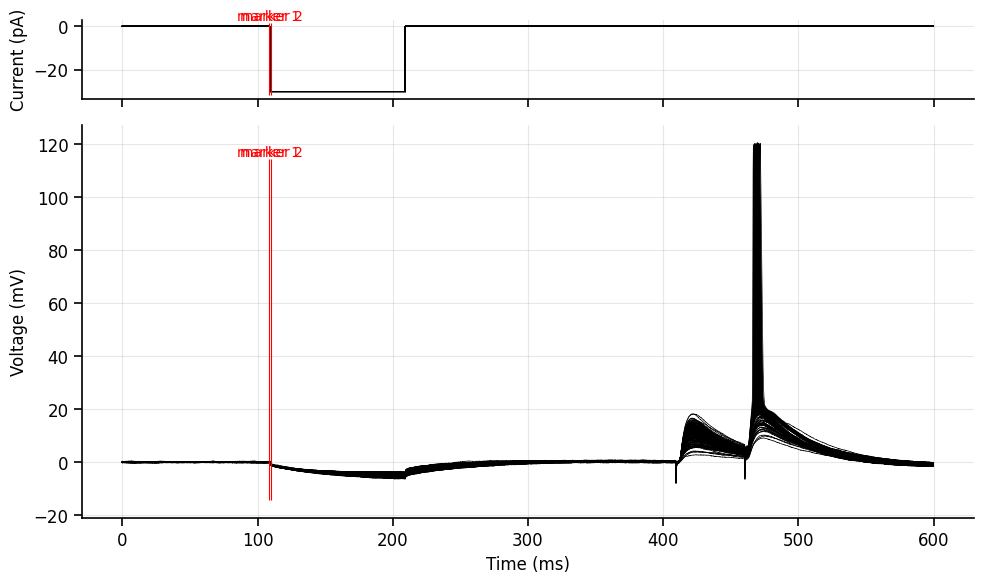

In [58]:
marker_1 = test_pulse_start[0] - 1  # Start of the marker window (in ms)
marker_2 = test_pulse_start[0] + 1    # End of the marker window (in ms)

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,5))
# ax1.set_xlim(start_time,end_time)
plt.show()

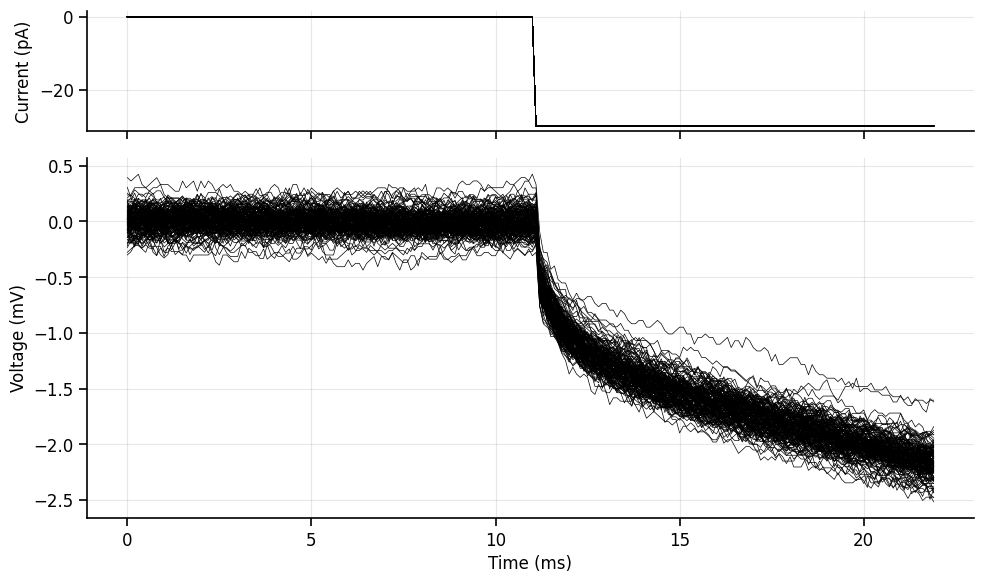

In [59]:
test_pulse_traces = traces.crop(timepoint=marker_1-10, timepoint_2=marker_2+10, time_units=time_units)
test_pulse_traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=(1,3))
plt.show()

### 3.2. Check that there haven't been any sudden big changes in the stim artifact (capacitive transient)

First let's re-baseline the data to just before the stimulus.

BASELINE SUBTRACTED:
Baseline voltages (mV): [0.294  0.228  0.597  ... 0.0708 0.3185 0.3568]


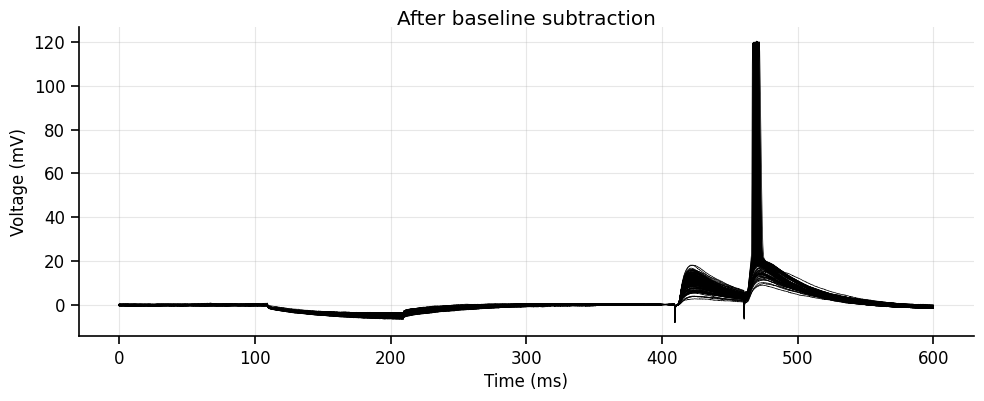

In [60]:
# Set these numbers to just before the first extracellular stimulus
baseline_start = 400
baseline_end = 405

traces.subtract_baseline(start_time = baseline_start, 
                        end_time = baseline_end , 
                        time_units = time_units,
                        channel = 'voltage')
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
ax1.set_title('After baseline subtraction', y=0.98)
plt.show()

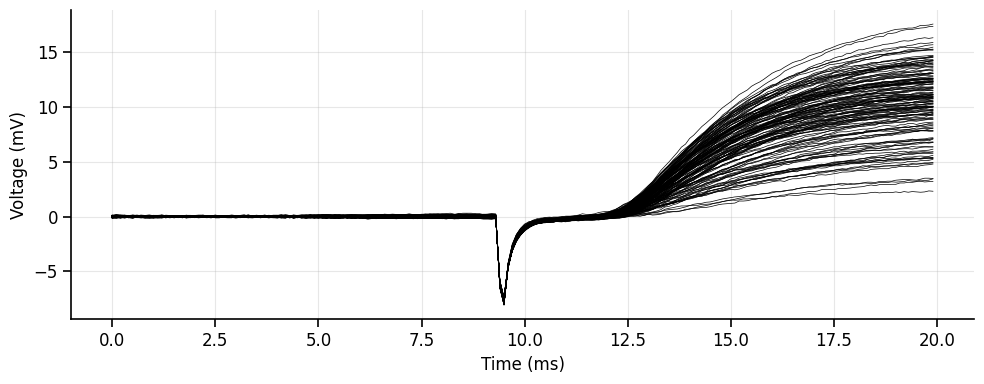

In [61]:
stim_artefact_traces = traces.crop(timepoint=baseline_start, timepoint_2=baseline_start+20, time_units=time_units)
stim_artefact_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all', height_ratios=(1,3))
plt.show()

### 3.4. Measure the first EPSP amplitude

Now you need to set the markers define the window for measuring the first EPSP

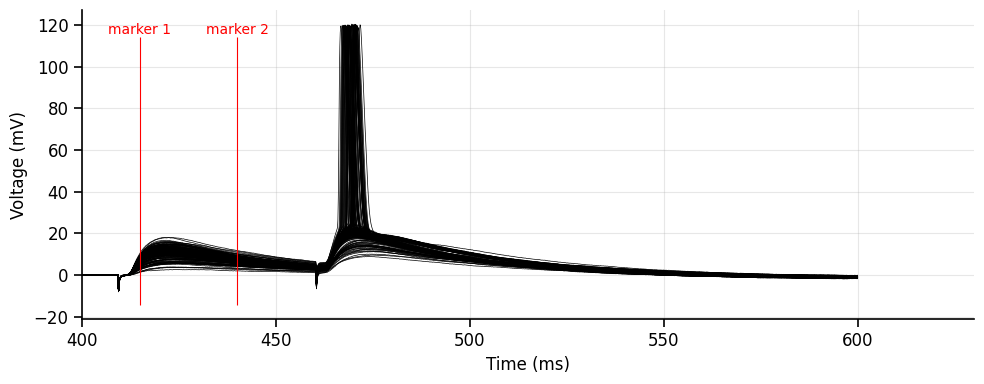

In [67]:
marker_1 = baseline_start + 15
marker_2 = baseline_start + 40

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(left=baseline_start)
plt.show()

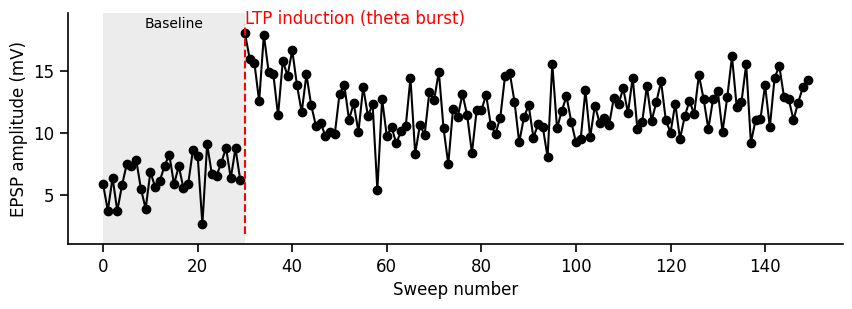

In [68]:
measurement_type = 'max' # Options: 'mean', 'max', 'min', 'peak'

_, epsp_peak = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                    measurement_type=measurement_type, time_units=time_units)


%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,epsp_peak[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, epsp_peak[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
plt.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Sweep number')
plt.show()

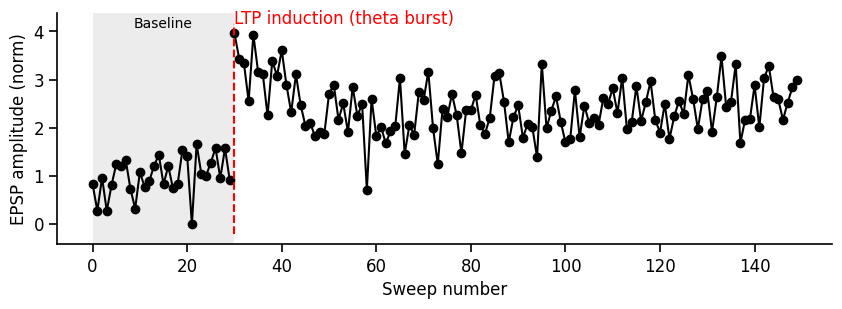

In [69]:
_epsp_peak = epsp_peak - np.min(epsp_peak)
avg_baseline_EPSP = np.mean(_epsp_peak[0:traces.num_baseline_sweeps])
normalized_EPSP_amplitudes = _epsp_peak / avg_baseline_EPSP

%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,normalized_EPSP_amplitudes[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2,normalized_EPSP_amplitudes[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
plt.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('EPSP amplitude (norm)')
ax.set_xlabel('Sweep number')
plt.show()

### **Optional: If you stimulated with paired-pulse (2 stimuli)**

### 3.4. Measure the second EPSP amplitude

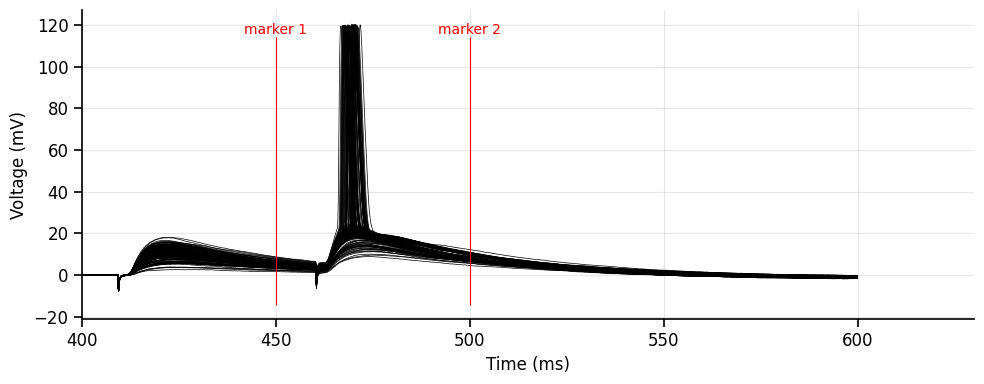

In [70]:
marker_1 = baseline_start + 50
marker_2 = baseline_start + 100

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, 
                      marker_1=marker_1, marker_2=marker_2, sweep='all', height_ratios=(1,3))
ax1.set_xlim(left=baseline_start)
plt.show()

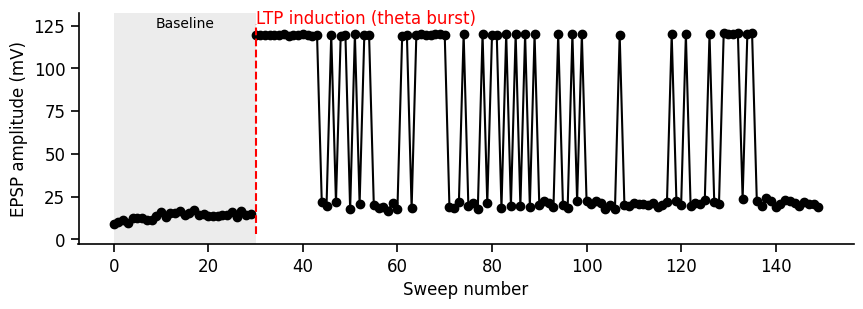

In [72]:
measurement_type = 'max' # Options: 'mean', 'max', 'min', 'peak'

_, voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                    measurement_type=measurement_type, time_units=time_units)


%matplotlib inline
fig,ax = plt.subplots(figsize=(10,3))
x1 = np.arange(traces.num_baseline_sweeps)
ax.plot(x1,voltage[0:traces.num_baseline_sweeps], '-o', color='black')
x2 = np.arange(traces.num_baseline_sweeps,traces.num_sweeps)
ax.plot(x2, voltage[traces.num_baseline_sweeps:], '-o', color='black')
ylims = ax.get_ylim()
ax.vlines(traces.num_baseline_sweeps, ylims[0], ylims[1], color='r', linestyle='--')
ax.annotate('LTP induction (theta burst)', xy=(traces.num_baseline_sweeps, ylims[1]), 
            xytext=(traces.num_baseline_sweeps, ylims[1]),color='r',fontsize=12)  
plt.axvspan(0, traces.num_baseline_sweeps, facecolor='gray', alpha=0.15)
ax.annotate('Baseline', xy=(traces.num_baseline_sweeps/2, ylims[1]), 
            xytext=(traces.num_baseline_sweeps/2, ylims[1]),color='k',fontsize=10, ha='center', va='center')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Sweep number')
plt.show()

### Bonus: Rainbow colours!

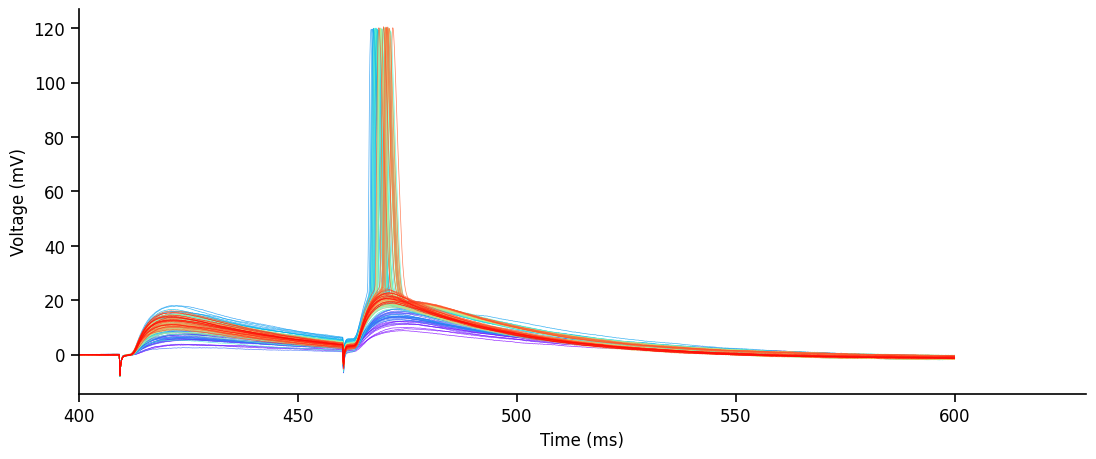

In [82]:
# cmap = plt.get_cmap('inferno')
# cmap = plt.get_cmap('Reds')
# cmap = plt.get_cmap('spring')
cmap = plt.get_cmap('rainbow')

fig, ax = plt.subplots(figsize=(13, 5))
for i in range(traces.num_sweeps):
    ax.plot(traces.time_ms, traces.voltage_data[i], color=cmap(i/traces.num_sweeps), linewidth=0.5, alpha=0.8)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_xlim(left=baseline_start)
plt.show()